# Instructions

### Analysis
1. Visualize genetic relatedness between the strains by performing principal component analysis and plotting the first two components.
1. Visualize the allele frequency spectrum by plotting a histogram of allele frequencies.
1. Using plink, perform quantitative association testing for each phenotype. Use the top 10 principal components (eigenvectors) as covariates in your analysis, to adjust for non-independence due to relatedness.
- Be sure to use the --allow-no-sex option
- You may find this portion of the plink documentation helpful for performing association testing on each of the phenotypes
1. For each phenotype, produce a QQ plot and Manhattan plot. For the Manhattan plot, highlight SNPs with p-values less than 10-5 in a different color.
1. Choose one of the traits for which you performed GWAS. For the top associated SNP, visualize the effect size by creating a boxplot of the phenotype stratified by genotype.

### Hints
You can easily perform the PCA and allele frequency calculations in Python, but plink can perform both as well. Either way, you will probably want to use matplotlib to produce the plots.
For PCA, be sure you have one datapoint per individual, as opposed to per SNP.
Each SNP only has one allele frequency.
Be careful about how you encode your phenotypes. plink expects both a family ID and a sample ID. In your VCF, they are separated by an underscore, but in your phenotype file they should be separated by a tab-character.


Submit
Submit to your qbb2020-answers repository:

All scripts
A record of your command-line commands, if applicable
All plots

### 1. Perform PCA and plot first two components

input: 
`plink --vcf BYxRM_segs_saccer3.bam.simplified.vcf   --pca --mind --allow-extra-chr`
output: 
`Results saved to plink.eigenval and plink.eigenvec`


In [1]:
#setting up
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Text(0, 0.5, 'PC2')

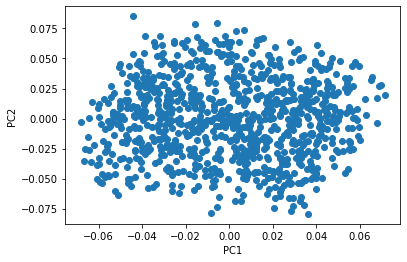

In [2]:
# tell pandas to read from file:
pca = pd.read_csv("data/plink.eigenvec", sep = " ", header=None)
pca
# use first two components for a plot:
fig, ax = plt.subplots()
ax.scatter(x = pca[2], y = pca[3])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

### 2. Plot a histogram of allele frequencies

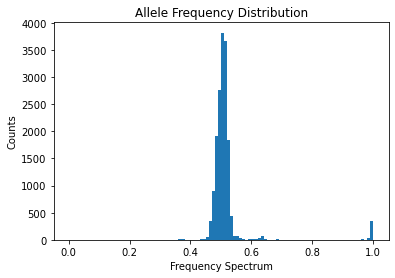

In [3]:
af = [] #create an empty list
vcf = open('data/BYxRM_segs_saccer3.bam.simplified.vcf', 'r')

#get the allele frequencies, copied from last week's assignment (with a bit of modification)
for i,line in enumerate(vcf): #reads per line
    if "#" in line:
        pass
    else:
        ann = line.split("\t") #splits by tab
        for j,field in enumerate(ann): 
            if "AF=" in field and "S" not in field: #looks for allele frequency
                if "," in field: #deals with annoying fields with comma separated values
                    comma_split = field.split(",") #splits these again
                    for m,field4 in enumerate(comma_split):
                        # now have to deal with the first value before the comma: 
                        if "=" in field4: # finds the "="
                            index = field4.index("=") #uses the "=" as an index
                            af.append(float(field4[index+1:])) #only appends the value after the index
                        else:
                            af.append(float(field4[:])) #adds each comma separated value to the list
                else: #adds non-annoying fields
                    af.append(float(field[3:])) #starting with after the "AF="
            else:
                pass
vcf.close()
af # display to ensure that the list was built


#plot figure
fig, ax = plt.subplots()
ax.hist(af, bins=100)
ax.set_title('Allele Frequency Distribution')
ax.set_ylabel('Counts')
ax.set_xlabel('Frequency Spectrum')
plt.show()
        

### 3. Perform quantitative association testing for each phenotype
Intrsuctions:
- Use the top 10 principal components (eigenvectors) as covariates in your analysis, to adjust for non-independence due to relatedness.
- Be sure to use the --allow-no-sex option
- See https://zzz.bwh.harvard.edu/plink/anal.shtml for documentation about quantitative association testing

--pheno <filename>

--mpheno <n>
--pheno-name <column name>
--all-pheno

--pheno-merge

--pheno causes phenotype values to be read from the 3rd column of the specified space- or tab-delimited file, instead of the .fam or .ped file. The first and second columns of that file must contain family and within-family IDs, respectively.

In combination with --pheno, --mpheno lets you use the (n+2)th column instead of the 3rd column, while --pheno-name lets you select a column by title. (In order to use --pheno-name, there must be a header row with first two entries 'FID' and 'IID'.) The new --pheno-merge flag tells PLINK to use the phenotype value in the .fam/.ped file when no value is present in the --pheno file; without it, the phenotype is always treated as missing in this case.


In [4]:
#we have to fix up the phenotype file so plink can read it:

#%%bash
#sed -e 's/_/   /g' data/BYxRM_PhenoData.txt > fixed.txt

# THE NEXT STEPS ARE COMMENTED OUT, BECAUSE I DON'T WANT THEM TO REPEATED WHEN I RE-RUN THE KERNEL
# ALSO, A BIT MORE FIXING UP WAS NECESSARY TO MAKE THE FILE READABLE, NOT REPRODUCED HERE

# we still need the header for FID and IID, 
#plus the bash script above ruined the first line

#replace the header lines with the ones from the original file:
#pheno = open('data/BYxRM_PhenoData.txt', 'r+')
#fixed = open('fixed.txt', 'w')

#headers = pheno.readlines()[:1] #write top line into fixed file
#for line in headers:
 #   fixed.seek(0, 0)
 #   head = fixed.write(line + '\t')

#add two header columns for FID and IID
#data = pheno.read() #assigns value to the whole file
#heading = "FID\tIID\t" #names what I want to add to the top
#pheno.seek(0, 0) #goes to the front of the first line 
#fixed.write(heading.rstrip('\r\n') + data) #adds 'heading' and new line, then the rest of the file

#fixed.close()
#pheno.close()



input into terminal: 
`plink \
  --vcf data/BYxRM_segs_saccer3.bam.simplified.vcf \
  --pheno data/fixed.txt \
  --linear \
  --all-pheno \
  --allow-no-sex \
  --covar data/plink.eigenvec \
  --covar-number 1-10 \
  --allow-extra-chr`

### 4. QQ plot and Manhattan plot for each phenotype

- For the Manhattan plot, highlight SNPs with p-values less than 10-5 in a different color.

first, try for the first phenotype and build a script

input into terminal: 
`plink \
  --vcf data/BYxRM_segs_saccer3.bam.simplified.vcf \
  --pheno data/fixed.txt \
  --assoc \
  --allow-no-sex`

In [12]:
#write a function to replace annoying yeast chr names:
def fix_yeast_chr(df):
    df = pd.DataFrame(df)
    df = df.replace('chrXIV', '14', regex=True) # replace all the yeast chr names
    df = df.replace('chrXVI', '16', regex=True) # have to do it in order that will not
    df = df.replace('chrXV', '15', regex=True)  # find parts of the roman numeral first
    df = df.replace('chrXIII', '13', regex=True)
    df = df.replace('chrXII', '12', regex=True)
    df = df.replace('chrXI', '11', regex=True)
    df = df.replace('chrIX', '9', regex=True)
    df = df.replace('chrIII', '3', regex=True)
    df = df.replace('chrII', '2', regex=True)
    df = df.replace('chrVIII', '8', regex=True)
    df = df.replace('chrVII', '7', regex=True)
    df = df.replace('chrVI', '6', regex=True)
    df = df.replace('chrIV', '4', regex=True)
    df = df.replace('chrV', '5', regex=True)
    df = df.replace('chrI', '1', regex=True)
    df = df.replace('chrX', '10', regex=True)
    df = df.replace('chrM', '26', regex=True)
    return(df)
    
gwas = pd.read_csv("plink.qassoc", sep = "\s+") #sends the qassoc file to pandas df
gwas['snp_index'] = range(len(gwas))
gwas['logP'] = -1 * np.log10(gwas['P']) #finds log p value and adds to dataframe
gwas = fix_yeast_chr(gwas)
display(gwas)

,CHR,SNP,BP,NMISS,BETA,SE,R2,T,P,snp_index,logP
0,1,.,1074,740,-0.5319,0.3545,0.003042,-1.5010,0.13390,0,0.873219
1,1,.,1101,743,-0.4247,0.3691,0.001784,-1.1510,0.25020,1,0.601713
2,1,.,1334,741,0.3263,0.3310,0.001313,0.9857,0.32460,2,0.488651
3,1,.,2223,566,-0.7841,0.3199,0.010540,-2.4510,0.01454,3,1.837436
4,1,.,2323,740,0.3134,0.3800,0.000921,0.8248,0.40980,4,0.387428
...,...,...,...,...,...,...,...,...,...,...,...
16619,16,.,942573,793,0.3955,0.4213,0.001113,0.9387,0.34820,16619,0.458171
16620,16,.,942580,795,-0.2728,0.4682,0.000428,-0.5827,0.56020,16620,0.251657
16621,16,.,942589,794,0.3704,0.4596,0.000820,0.8060,0.42050,16621,0.376234
16622,16,.,942644,787,0.7349,0.4421,0.003508,1.6620,0.09684,16622,1.013945


In [6]:
#build a list of all the phenotypes from the original file
pheno = open('data/BYxRM_PhenoData.txt', 'r')

phenotypes = []
for line in pheno.readlines()[:1]:
    heading = line.split("\t")
    for field in heading:
        phenotypes.append(field)

pheno.close()

In [69]:
#now make a function for reading each plink phenotype file into a dataframe

def phenoplots(plinkfile):
    
    gwas_raw = plinkfile #read file into pandas
    gwas_fun = fix_yeast_chr(gwas_raw) #fix yeast chromosome names
    gwas_fun['logP'] = -1 * np.log10(gwas_fun["P"]) # add log p value column from p column
    gwas_fun['snp_index'] = range(len(gwas_fun)) # add snp counter
    return(gwas_fun)
    

In [73]:
#write function for making manahattan plot and QQ plot

def makeplots(gwas, name):
    fig, axs = plt.subplots(1,2) 
    for chrom in range(1, 26): #iterate for each chromosome (1-16,26)
        axs[0].scatter(gwas["snp_index"][gwas["CHR"] == str(chrom)][gwas["logP"] >= 5], gwas["logP"][gwas["CHR"] == str(chrom)][gwas["logP"] >= 5], color = "lime", marker = '.')
        axs[0].scatter(gwas["snp_index"][gwas["CHR"] == str(chrom)][gwas["logP"] < 5], gwas["logP"][gwas["CHR"] == str(chrom)][gwas["logP"] < 5], marker = '.')
    
    axs[0].set_xlabel("SNPs")
    axs[0].set_ylabel("-log10(p-value)")
    axs[0].set_title(name)
    
    #copying from Rajiv's notebook:
    gwas_sorted = gwas.sort_values(by = "P")
    gwas_sorted['uniform_points'] = range(0, len(gwas_sorted))
    gwas_sorted['uniform_pval'] = (gwas_sorted['uniform_points'] + 1) / len(gwas_sorted)
    gwas_sorted['uniform_logP'] = -1 * np.log10(gwas_sorted['uniform_pval'])

    axs[1].scatter(gwas_sorted["uniform_logP"], gwas_sorted["logP"])
    axs[1].plot([8,0], [8, 0], color = "black")
    axs[1].set_xlim([0, 8])
    axs[1].set_ylim([0, 10])
    axs[1].set_xlabel("Expected -log10(p-value)")
    axs[1].set_ylabel("Observed -log10(p-value)")
    axs[1].set_title(name)

    plt.show()


Cadmium_Chloride


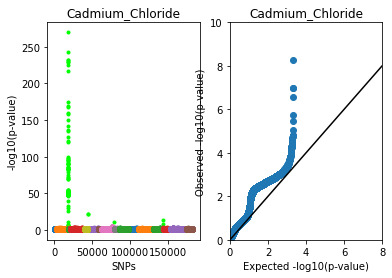

Caffeine


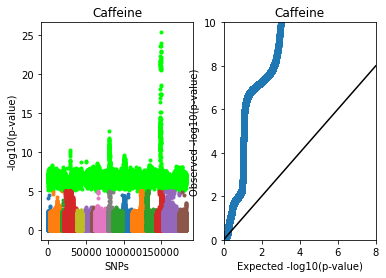

Calcium_Chloride


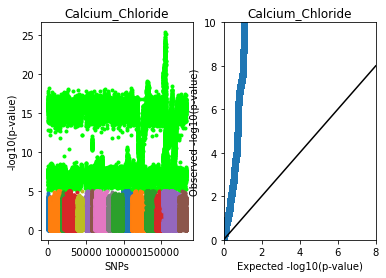

Cisplatin


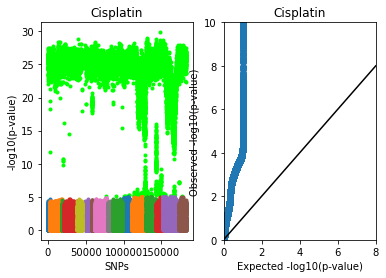

Cobalt_Chloride


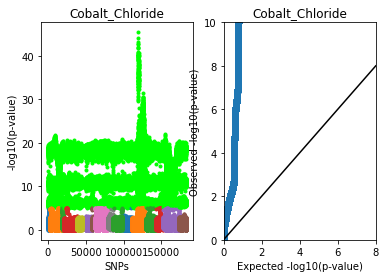

Congo_red


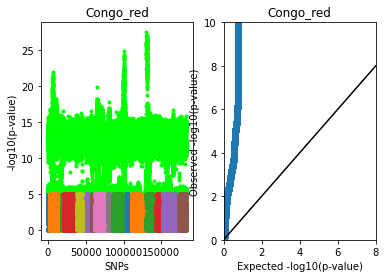

Copper


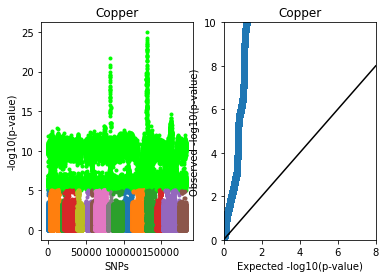

Cycloheximide


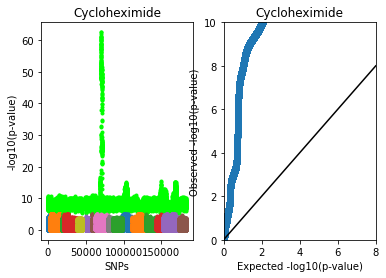

Diamide


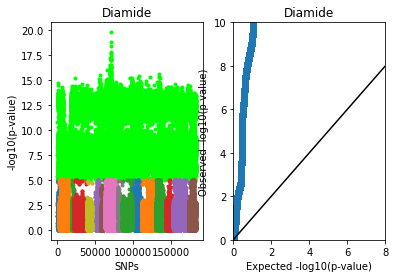

E6_Berbamine


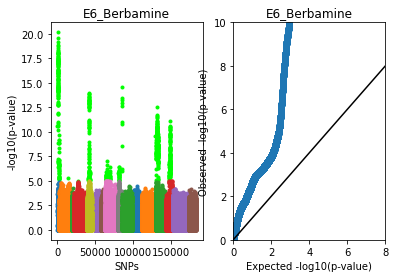

Ethanol


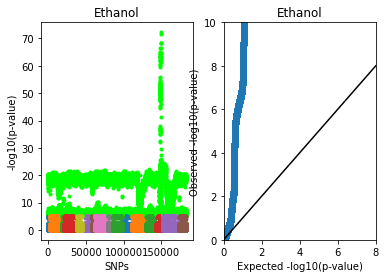

Formamide


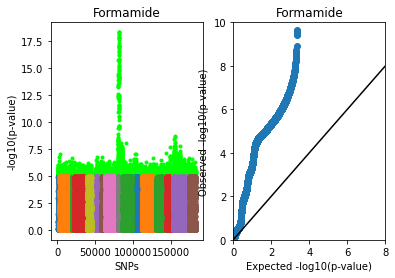

Galactose


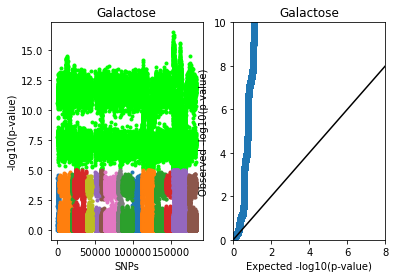

Hydrogen_Peroxide


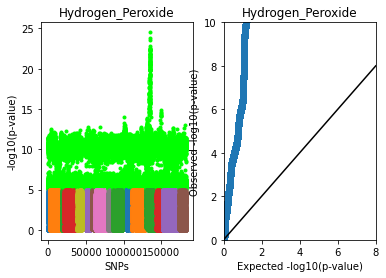

Hydroquinone


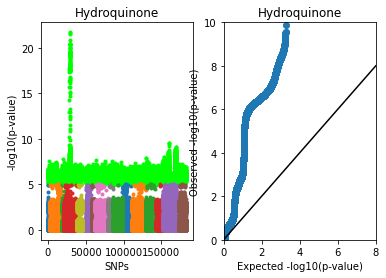

Hydroxyurea


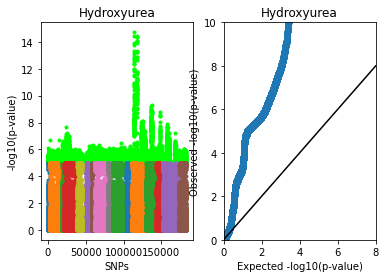

Indoleacetic_Acid


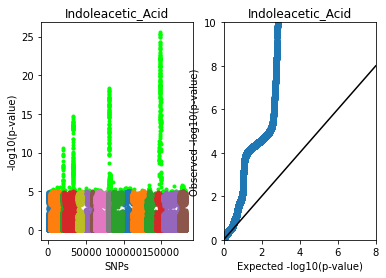

Lactate


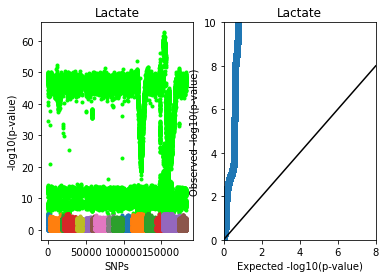

Lactose


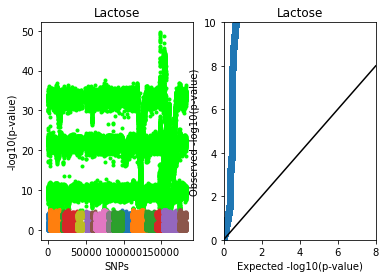

Lithium_Chloride


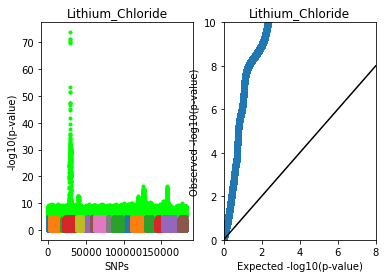

Magnesium_Chloride


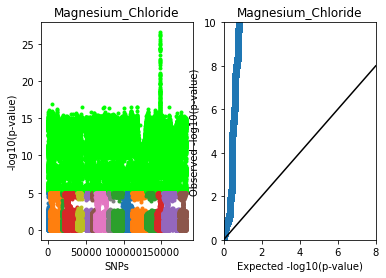

Magnesium_Sulfate


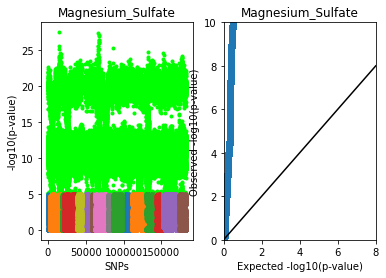

Maltose


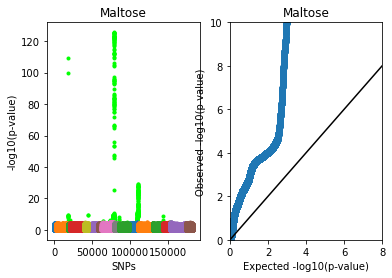

Mannose


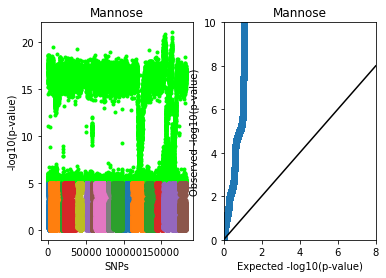

Menadione


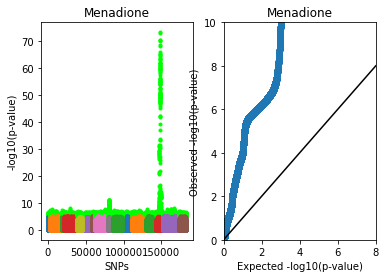

Neomycin


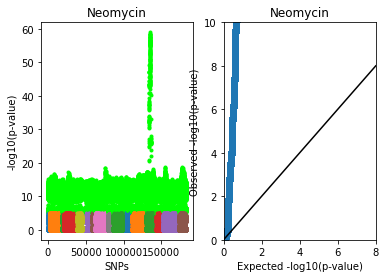

Paraquat


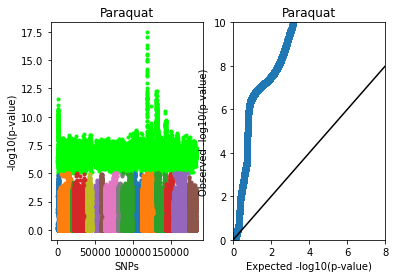

Raffinose


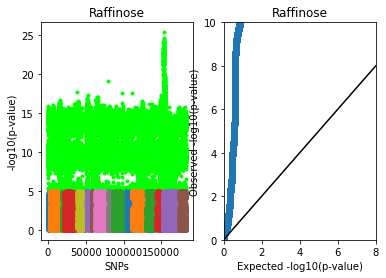

SDS


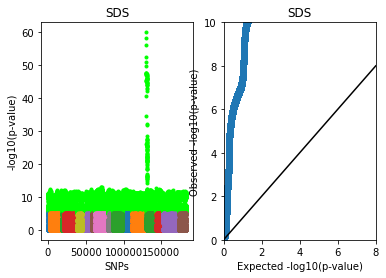

Sorbitol


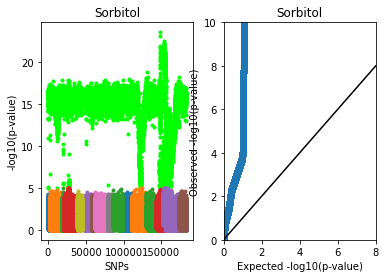

Trehalose


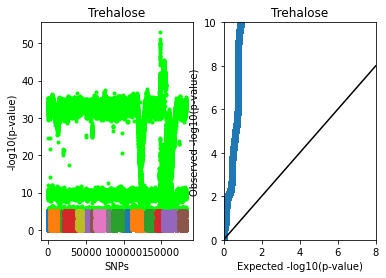

Tunicamycin


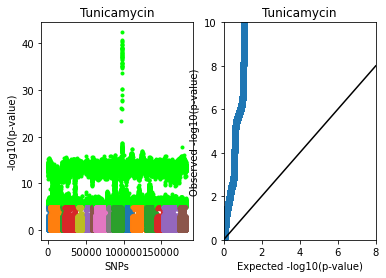

x4-Hydroxybenzaldehyde


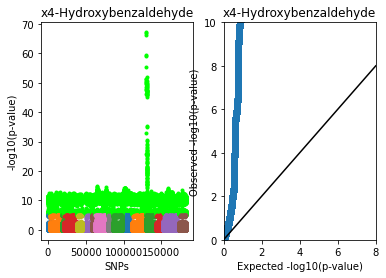

x4NQO


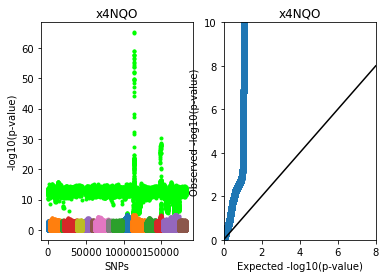

x5-Fluorocytosine


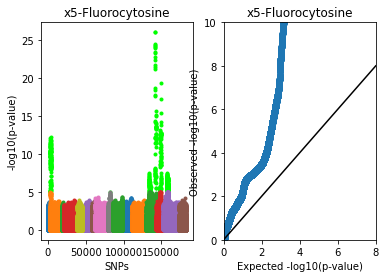

x5-Fluorouracil


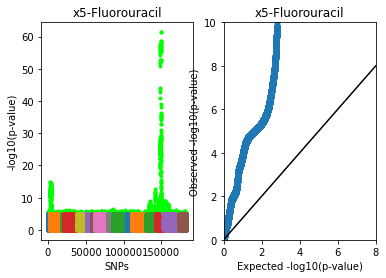

x6-Azauracil


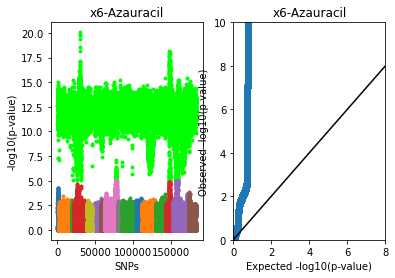

Xylose


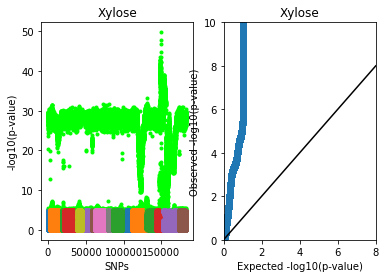

YNB


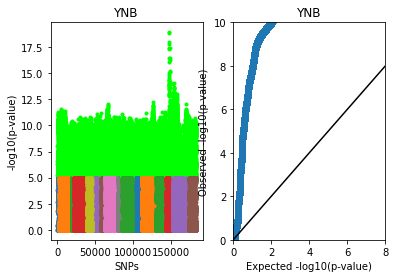

YNB:ph3


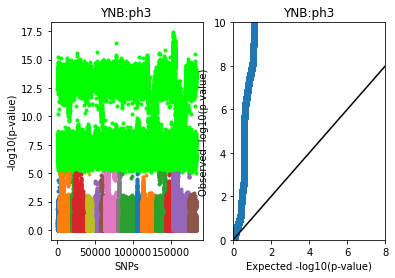

YNB:ph8


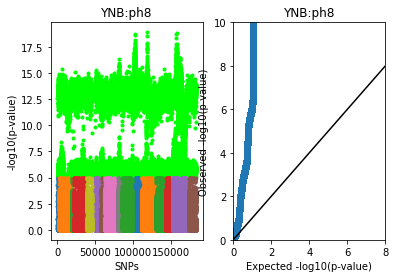

YPD


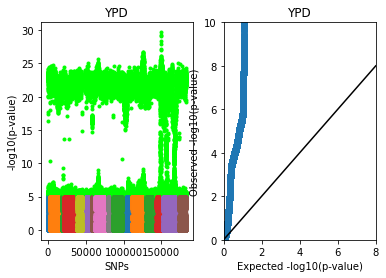

YPD:15C


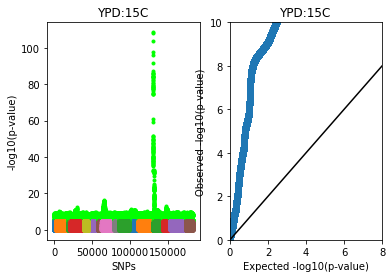

YPD:37C


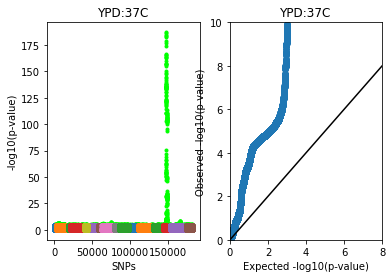

YPD:4C


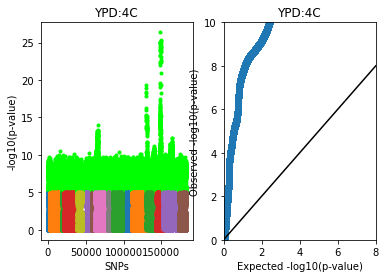

FileNotFoundError: [Errno 2] No such file or directory: 'plink.Zeocin\n.assoc.linear'

In [74]:
#putting it all together using the list of phenotype names

for row in range(0, 50):
    phenfile = pd.read_csv("plink." + phenotypes[row] + ".assoc.linear", sep = "\s+")
    print(phenotypes[row])
    df = phenoplots(phenfile)
    plots = makeplots(df, phenotypes[row])

    
 

### Visualize the effect size of the top associated SNP for any single trait

Choose one of the traits for which you performed GWAS. For the top associated SNP, create a boxplot of the phenotype stratified by genotype.


In [87]:
#find the top associated SNP for a particular phenotype:
#using "Caffeine" so that I can make a lame pun and call it a "CafPhene" 

cafphen = pd.read_csv("plink.Caffeine.assoc.linear", sep = "\s+")
caf_sorted = cafphen.sort_values(by = "P",ascending=True)

caf_sorted

,CHR,SNP,BP,A1,TEST,NMISS,BETA,STAT,P
148951,chrXIV,.,466103,G,ADD,900,0.3159,10.90,4.672000e-26
148984,chrXIV,.,467219,A,ADD,910,0.3062,10.56,1.222000e-24
148962,chrXIV,.,466588,T,ADD,908,0.3013,10.48,2.465000e-24
148742,chrXIV,.,445766,A,ADD,907,-0.3033,-10.46,2.953000e-24
148918,chrXIV,.,464117,A,ADD,902,0.3026,10.33,1.046000e-23
...,...,...,...,...,...,...,...,...,...
182089,chrXVI,.,890346,T,COV6,847,NaN,NaN,NaN
182090,chrXVI,.,890346,T,COV7,847,NaN,NaN,NaN
182091,chrXVI,.,890346,T,COV8,847,NaN,NaN,NaN
182092,chrXVI,.,890346,T,COV9,847,NaN,NaN,NaN


In [88]:
#select SNP at BP=466103
caf_sorted.loc[148951]

CHR         chrXIV
SNP              .
BP          466103
A1               G
TEST           ADD
NMISS          900
BETA        0.3159
STAT          10.9
P        4.672e-26
Name: 148951, dtype: object

In [105]:
#stolen goods

genotypes=open("data/BYxRM_segs_saccer3.bam.simplified.vcf")

snp_list=[]

#read genotypes into list
for line in genotypes:
    if "chrXIV" and "466103" in line:
        #use similar method as above and last assignment
        #collect genotype data by starting after GT:DP        
        gdata = line.split("DP") 
        for l in gdata:
            ann = field.split("\t") #splits by tab
            for j in ann:
                if '0/0' in j:
                    snp_list.append('wild-type')
                elif '0/1' in j:
                    snp_list.append('heterozygous')
                elif '1/1' in j:
                    snp_list.append('homo-polymorphism') 

snp_list

['homo-polymorphism',
 'homo-polymorphism',
 'homo-polymorphism',
 'homo-polymorphism']

In [111]:
#sstolennn



pheno_dict={}
pheno_dict['wild-type']=[]
pheno_dict['heterozygous']=[]
pheno_dict['homo-polymorphism']=[]

phenotypes=open("data/BYxRM_PhenoData.txt")


phenotypes.close()